<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#План-проекта" data-toc-modified-id="План-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>План проекта</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## План проекта
**2. Подготовка данных**
* Импорт необходимых библиотек
* Чтение файлов и сохранение полученных данных в переменные
* Получение общей информации о таблицах (head, info, describe)
* Проверка рассчета эффективности обогащения
* Анализ признаков
* Предобработка данных
* Выводы

**3. Анализ данных:**
* Анализ измменения концентрации металлов на различных этапах очистки
* Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках
* Исследование суммарной концентрации всех веществ на разных стадиях
* Выводы

**4. Модель:**
* Обучение моделей
* Выбор лучшей модели
* Выводы

**5. Общий вывод**


## Подготовка данных

In [264]:
!pip install optuna

In [265]:
# Импортируем нужные библиотеки
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import math
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold

import optuna

import time

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

from sklearn.dummy import DummyRegressor

In [266]:
RANDOM_STATE = 12345

In [267]:
# Напишем функцию для первичной проверки данных
def check_data(data_df):
    print ('\033[1m' + 'Изучим исходные данные'+ '\033[0m')
    print(data_df.info())
    #print(data_df.shape)
        
    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())
        
    ## Посмотрим на сами данные
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data_df.head())
    
    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)

In [268]:
def fill_missing_values(df):
    df = df.copy()  # создадим копию датафрейма для избежания изменений исходного датафрейма
    
    # Цикл по каждому столбцу датафрейма
    for col in df.columns:
        col_data = df[col].values
        missing_mask = pd.isnull(col_data)  # создадим маску, для определения пропущенных значений
        
        # Цикл по каждому пропущенному значению в столбце
        for idx in np.where(missing_mask)[0]:
            above_idx = idx - 1
            below_idx = idx + 1
            
            # Находим близжайщие непропущенные значения выше и ниже пропущенного значения
            while above_idx >= 0 and pd.isnull(col_data[above_idx]):
                above_idx -= 1
            while below_idx < len(col_data) and pd.isnull(col_data[below_idx]):
                below_idx += 1
                
            # Считаем среднее непропущенных значений
            if above_idx >= 0 and below_idx < len(col_data):
                avg_val = (col_data[above_idx] + col_data[below_idx]) / 2.0
            elif above_idx >= 0:
                avg_val = col_data[above_idx]
            elif below_idx < len(col_data):
                avg_val = col_data[below_idx]
            
            # Заменяем пропущенное значение средним значением
            col_data[idx] = avg_val
        
        df[col] = col_data  # заменяем столбец в датафрейме столбцом с заполненными значениями
    
    return df

In [269]:
# Считываем данные из csv-файлов в датафреймы и сохраняем в переменных geo_data_0, geo_data_1, geo_data_2
try:
    gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
except:
    gold_recovery_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv')
    gold_recovery_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv')
    gold_recovery_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv')   

In [270]:
gold_recovery_train.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [271]:
gold_recovery_test.head(5)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [272]:
gold_recovery_full.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [273]:
# приведем названия столбцов к змеиному регистру
gold_recovery_train.columns = gold_recovery_train.columns.str.lower().str.replace('.', '_')
gold_recovery_test.columns = gold_recovery_test.columns.str.lower().str.replace('.', '_')
gold_recovery_full.columns = gold_recovery_full.columns.str.lower().str.replace('.', '_')

In [274]:
gold_recovery_full.head(2)

,date,final_output_concentrate_ag,final_output_concentrate_pb,final_output_concentrate_sol,final_output_concentrate_au,final_output_recovery,final_output_tail_ag,final_output_tail_pb,final_output_tail_sol,final_output_tail_au,...,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184


Загруженные таблицы соответствует заданию. В нашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверим их на корректность.

Целевой признак:

final_output_recovery — коэффициент восстановления золота из золотосодержащей руды.

Проверимьте, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher_output_recovery.

In [275]:
c_out = gold_recovery_train['rougher_output_concentrate_au']
c_in = gold_recovery_train['rougher_input_feed_au']
tail = gold_recovery_train['rougher_output_tail_au']

gold_recovery_train['recovery_calculated'] = ((c_out * (c_in - tail)) / (c_in * (c_out - tail))) * 100

In [276]:
print(mean_absolute_error(gold_recovery_train['recovery_calculated'],gold_recovery_train['rougher_output_recovery']))

9.73512347450521e-15


Как видим из низкого значния MAE эффективность обогащения рассчитана правильно.

In [277]:
gold_recovery_train = gold_recovery_train.drop(['recovery_calculated'], axis=1)

In [278]:
# описательный анализ полной выборки
check_data(gold_recovery_full)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final_output_concentrate_ag                         19438 non-null  float64
 2   final_output_concentrate_pb                         19438 non-null  float64
 3   final_output_concentrate_sol                        19228 non-null  float64
 4   final_output_concentrate_au                         19439 non-null  float64
 5   final_output_recovery                               19439 non-null  float64
 6   final_output_tail_ag                                19438 non-null  float64
 7   final_output_tail_pb                                19338 non-null  float64
 8   final_output_tail_sol                               1

,date,final_output_concentrate_ag,final_output_concentrate_pb,final_output_concentrate_sol,final_output_concentrate_au,final_output_recovery,final_output_tail_ag,final_output_tail_pb,final_output_tail_sol,final_output_tail_au,...,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
final_output_concentrate_ag,19438.0,5.168470,1.372348,0.000000,4.251240,5.066094,5.895527,16.001945
final_output_concentrate_pb,19438.0,9.978895,1.669240,0.000000,9.137262,10.102433,11.035769,17.031899
final_output_concentrate_sol,19228.0,9.501224,2.787537,0.000000,7.722820,9.218961,10.947813,19.615720
final_output_concentrate_au,19439.0,44.076513,5.129784,0.000000,43.402215,45.011244,46.275313,52.756638
final_output_recovery,19439.0,67.050208,10.125840,0.000000,63.299712,68.172738,72.686642,100.000000
...,...,...,...,...,...,...,...,...
secondary_cleaner_state_floatbank5_a_level,19438.0,-488.684065,34.533396,-797.323986,-500.458467,-499.802605,-498.384187,-244.483566
secondary_cleaner_state_floatbank5_b_air,19438.0,12.198224,5.333024,0.528083,8.971105,11.019433,14.019088,27.926001
secondary_cleaner_state_floatbank5_b_level,19438.0,-487.149827,38.347312,-800.220337,-500.129462,-499.935317,-499.436708,-137.740004
secondary_cleaner_state_floatbank6_a_air,19437.0,18.959024,5.550498,-0.079426,14.983037,19.960541,24.003170,32.188906


In [279]:
# описательный анализ тестовой выборки
check_data(gold_recovery_test)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner_input_sulfate               5286 non-null   float64
 2   primary_cleaner_input_depressant            5285 non-null   float64
 3   primary_cleaner_input_feed_size             5290 non-null   float64
 4   primary_cleaner_input_xanthate              5286 non-null   float64
 5   primary_cleaner_state_floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner_state_floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner_state_floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner_state_floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner_state_floatbank8_c_air      5290 non-null   fl

,date,primary_cleaner_input_sulfate,primary_cleaner_input_depressant,primary_cleaner_input_feed_size,primary_cleaner_input_xanthate,primary_cleaner_state_floatbank8_a_air,primary_cleaner_state_floatbank8_a_level,primary_cleaner_state_floatbank8_b_air,primary_cleaner_state_floatbank8_b_level,primary_cleaner_state_floatbank8_c_air,...,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
primary_cleaner_input_sulfate,5286.0,174.839652,43.027080,2.566156e+00,147.121401,177.828489,208.125438,265.983123
primary_cleaner_input_depressant,5285.0,8.683596,3.072050,3.839482e-03,6.489555,8.052207,10.027764,40.000000
primary_cleaner_input_feed_size,5290.0,7.266339,0.610219,5.650000e+00,6.890000,7.250000,7.600000,15.500000
primary_cleaner_input_xanthate,5286.0,1.383803,0.643474,4.983673e-03,0.907623,1.197610,1.797819,4.102454
primary_cleaner_state_floatbank8_a_air,5290.0,1539.494325,116.797884,5.445860e-32,1498.935802,1585.129123,1602.076529,2103.103580
primary_cleaner_state_floatbank8_a_level,5290.0,-497.665883,19.952431,-7.953163e+02,-500.357298,-499.969164,-499.568951,-57.195404
primary_cleaner_state_floatbank8_b_air,5290.0,1545.174232,122.224588,6.647490e-32,1498.970993,1595.621798,1602.323545,1813.083671
primary_cleaner_state_floatbank8_b_level,5290.0,-500.273098,32.968307,-7.999970e+02,-500.703002,-500.028514,-499.293257,-142.527229
primary_cleaner_state_floatbank8_c_air,5290.0,1527.272362,122.538034,4.033736e-32,1473.229862,1549.594682,1601.143775,1715.053773
primary_cleaner_state_floatbank8_c_level,5290.0,-498.330680,21.964876,-7.999606e+02,-501.018117,-500.017711,-498.994130,-150.937035


In [280]:
# описательный анализ обучающей выборки
check_data(gold_recovery_train)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final_output_concentrate_ag                         14148 non-null  float64
 2   final_output_concentrate_pb                         14148 non-null  float64
 3   final_output_concentrate_sol                        13938 non-null  float64
 4   final_output_concentrate_au                         14149 non-null  float64
 5   final_output_recovery                               14149 non-null  float64
 6   final_output_tail_ag                                14149 non-null  float64
 7   final_output_tail_pb                                14049 non-null  float64
 8   final_output_tail_sol                               1

,date,final_output_concentrate_ag,final_output_concentrate_pb,final_output_concentrate_sol,final_output_concentrate_au,final_output_recovery,final_output_tail_ag,final_output_tail_pb,final_output_tail_sol,final_output_tail_au,...,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
final_output_concentrate_ag,14148.0,5.142034,1.369586,0.000000,4.211620,4.994652,5.859540,16.001945
final_output_concentrate_pb,14148.0,10.132960,1.654930,0.000000,9.297355,10.297144,11.170603,17.031899
final_output_concentrate_sol,13938.0,9.202849,2.790516,0.000000,7.484645,8.845462,10.487508,18.124851
final_output_concentrate_au,14149.0,44.003792,4.905261,0.000000,43.276111,44.872436,46.166425,52.756638
final_output_recovery,14149.0,66.518832,10.295402,0.000000,62.545817,67.432775,72.346428,100.000000
...,...,...,...,...,...,...,...,...
secondary_cleaner_state_floatbank5_a_level,14148.0,-483.956022,37.892788,-797.142475,-500.363177,-499.702452,-487.712108,-275.073125
secondary_cleaner_state_floatbank5_b_air,14148.0,13.064590,5.765617,0.646208,8.994405,11.997547,17.982903,27.926001
secondary_cleaner_state_floatbank5_b_level,14148.0,-483.966564,39.207913,-800.006180,-500.105994,-499.914556,-453.186936,-157.396071
secondary_cleaner_state_floatbank6_a_air,14147.0,19.577539,5.764417,0.195324,14.989304,19.984175,24.991623,32.188906


In [281]:
# В тестовой выборке не доступны следующие параметры
missing_in_test = [x for x in gold_recovery_full.columns if x not in gold_recovery_test.columns]

missing_in_test

['final_output_concentrate_ag',
 'final_output_concentrate_pb',
 'final_output_concentrate_sol',
 'final_output_concentrate_au',
 'final_output_recovery',
 'final_output_tail_ag',
 'final_output_tail_pb',
 'final_output_tail_sol',
 'final_output_tail_au',
 'primary_cleaner_output_concentrate_ag',
 'primary_cleaner_output_concentrate_pb',
 'primary_cleaner_output_concentrate_sol',
 'primary_cleaner_output_concentrate_au',
 'primary_cleaner_output_tail_ag',
 'primary_cleaner_output_tail_pb',
 'primary_cleaner_output_tail_sol',
 'primary_cleaner_output_tail_au',
 'rougher_calculation_sulfate_to_au_concentrate',
 'rougher_calculation_floatbank10_sulfate_to_au_feed',
 'rougher_calculation_floatbank11_sulfate_to_au_feed',
 'rougher_calculation_au_pb_ratio',
 'rougher_output_concentrate_ag',
 'rougher_output_concentrate_pb',
 'rougher_output_concentrate_sol',
 'rougher_output_concentrate_au',
 'rougher_output_recovery',
 'rougher_output_tail_ag',
 'rougher_output_tail_pb',
 'rougher_output_ta

In [282]:
len(missing_in_test)

34

В тестовой выборке не доступны значения концентратов ag, pb, sol, au (грубых, финальных и после первичного очистителя), "хвостов" ag, pb, sol, au (первичных, вторичных, финальных и после первичного очистителя). А также в тестовой выборке отстутсвуют признаки: rougher_calculation_sulfate_to_au_concentrate, rougher_calculation_floatbank10_sulfate_to_au_feed, rougher_calculation_floatbank11_sulfate_to_au_feed. Скорее всего это значения рассчетов, которые рассчитываются позже, во время процесса обогащения. 
Все признаки, не доступные в тестовой выборке относятся к численные переменным.

Доля строк содержащих пропуски в тестовой выборке достаточно мала (1.2%). Поэтому пропущенные строки можно удалить из датасета.

In [283]:
gold_recovery_test = gold_recovery_test.dropna()

In [284]:
# Проверим данные после удаления пропусков
check_data(gold_recovery_test)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5229 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5229 non-null   object 
 1   primary_cleaner_input_sulfate               5229 non-null   float64
 2   primary_cleaner_input_depressant            5229 non-null   float64
 3   primary_cleaner_input_feed_size             5229 non-null   float64
 4   primary_cleaner_input_xanthate              5229 non-null   float64
 5   primary_cleaner_state_floatbank8_a_air      5229 non-null   float64
 6   primary_cleaner_state_floatbank8_a_level    5229 non-null   float64
 7   primary_cleaner_state_floatbank8_b_air      5229 non-null   float64
 8   primary_cleaner_state_floatbank8_b_level    5229 non-null   float64
 9   primary_cleaner_state_floatbank8_c_air      5229 non-null   fl

,date,primary_cleaner_input_sulfate,primary_cleaner_input_depressant,primary_cleaner_input_feed_size,primary_cleaner_input_xanthate,primary_cleaner_state_floatbank8_a_air,primary_cleaner_state_floatbank8_a_level,primary_cleaner_state_floatbank8_b_air,primary_cleaner_state_floatbank8_b_level,primary_cleaner_state_floatbank8_c_air,...,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
primary_cleaner_input_sulfate,5229.0,175.842593,41.794368,1.788690e+01,147.892868,178.326782,208.365965,265.983123
primary_cleaner_input_depressant,5229.0,8.714363,3.022147,1.133559e-01,6.494356,8.066361,10.033999,20.046764
primary_cleaner_input_feed_size,5229.0,7.271546,0.605887,5.650000e+00,6.900000,7.250000,7.600000,15.500000
primary_cleaner_input_xanthate,5229.0,1.391267,0.640898,2.629347e-02,0.912160,1.198638,1.801643,4.102454
primary_cleaner_state_floatbank8_a_air,5229.0,1539.976462,111.182711,1.011533e+03,1498.958074,1585.303338,1602.113128,1810.767191
primary_cleaner_state_floatbank8_a_level,5229.0,-497.767407,18.120451,-7.834486e+02,-500.357716,-499.972297,-499.575397,-57.195404
primary_cleaner_state_floatbank8_b_air,5229.0,1546.004743,117.787666,1.012934e+03,1498.927702,1595.815696,1602.359135,1813.083671
primary_cleaner_state_floatbank8_b_level,5229.0,-499.929614,29.847282,-7.997549e+02,-500.700274,-500.031165,-499.303764,-142.527229
primary_cleaner_state_floatbank8_c_air,5229.0,1529.120511,117.176468,2.120354e+02,1474.759195,1549.773169,1601.221336,1715.053773
primary_cleaner_state_floatbank8_c_level,5229.0,-498.389260,20.273044,-7.862603e+02,-501.013437,-500.021560,-499.005152,-150.937035


По условию задачи сказано что соседние по времени параметры часто похожи, а доля строк содержащих пропуски в обучающей выборке достаточно велика (22.1%). Удаление пропущенных значений приведет к ухудшению качества модели. Поэтому заполним пропущенные значение средним значением ячейки выше и ниже пропущенной.

In [285]:
gold_recovery_train_filled = fill_missing_values(gold_recovery_train)

In [286]:
# Проверим данные после заполенения пропусков
check_data(gold_recovery_train_filled)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final_output_concentrate_ag                         14149 non-null  float64
 2   final_output_concentrate_pb                         14149 non-null  float64
 3   final_output_concentrate_sol                        14149 non-null  float64
 4   final_output_concentrate_au                         14149 non-null  float64
 5   final_output_recovery                               14149 non-null  float64
 6   final_output_tail_ag                                14149 non-null  float64
 7   final_output_tail_pb                                14149 non-null  float64
 8   final_output_tail_sol                               1

,date,final_output_concentrate_ag,final_output_concentrate_pb,final_output_concentrate_sol,final_output_concentrate_au,final_output_recovery,final_output_tail_ag,final_output_tail_pb,final_output_tail_sol,final_output_tail_au,...,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
final_output_concentrate_ag,14149.0,5.141918,1.369607,0.000000,4.211500,4.994607,5.859495,16.001945
final_output_concentrate_pb,14149.0,10.132845,1.654928,0.000000,9.296833,10.297013,11.170578,17.031899
final_output_concentrate_sol,14149.0,9.122861,2.865656,0.000000,7.426626,8.808419,10.457103,18.124851
final_output_concentrate_au,14149.0,44.003792,4.905261,0.000000,43.276111,44.872436,46.166425,52.756638
final_output_recovery,14149.0,66.518832,10.295402,0.000000,62.545817,67.432775,72.346428,100.000000
...,...,...,...,...,...,...,...,...
secondary_cleaner_state_floatbank5_a_level,14149.0,-483.957101,37.891666,-797.142475,-500.363169,-499.702424,-487.864322,-275.073125
secondary_cleaner_state_floatbank5_b_air,14149.0,13.064233,5.765570,0.646208,8.994384,11.997537,17.982826,27.926001
secondary_cleaner_state_floatbank5_b_level,14149.0,-483.967715,39.206766,-800.006180,-500.105994,-499.914556,-453.274822,-157.396071
secondary_cleaner_state_floatbank6_a_air,14149.0,19.576673,5.764495,0.195324,14.989244,19.984165,24.991615,32.188906


Проверим на сколько изменились средние значения всех столбцов после заполнения пропущенных значений, для этого используем метрику RMSE.

In [287]:
print(mean_squared_error(gold_recovery_train.describe().T['mean'], gold_recovery_train_filled.describe().T['mean']))

0.020645388929935428


Как видим, средние значение не очень поменялись, значение RMSE всего лишь 0.02. Поэтому для обчуения нашей модели будем использовать датафрейм с заполненными значениями.

**Вывод: Данные в датасете обработаны. Был проверен расчет эффективности обогащения, проанализированы признаки. Удалены строки с пропущенными значениями для тестовой выборки, для тренировочной выборки пропущенные значения были заменены на среднее значение ячеек рядом находящихся ячеек (апроксимация), произведена проверка того, что в датасете нету дубликатов. Можно приступать к исследованию.**

## Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.  
Для восстановления золота из золотосодержащей руды существует три этапа очистки:
* rougher
* primary_cleaner
* final

In [288]:
metals = ['ag', 'pb', 'au']
processes = ['rougher_input_feed',
             'rougher_output_concentrate',
             'primary_cleaner_output_concentrate',
             'final_output_concentrate'
            ]

concentrate_ag_list = []
concentrate_pb_list = []
concentrate_au_list = []

for process in processes:
    concentrate_ag = round(gold_recovery_full[process+'_'+metals[0]].mean(), 2)
    concentrate_pb = round(gold_recovery_full[process+'_'+metals[1]].mean(), 2)
    concentrate_au = round(gold_recovery_full[process+'_'+metals[2]].mean(), 2)
    
    concentrate_ag_list.append(concentrate_ag)
    concentrate_pb_list.append(concentrate_pb)
    concentrate_au_list.append(concentrate_au)
    
    print('На этапе {0} | концентрация {1}: {2}, концентрация {3}: {4}, концентрация {5}: {6}'.format(process,
                                                                                                    metals[0],
                                                                                                    concentrate_ag,
                                                                                                    metals[1],
                                                                                                    concentrate_pb,
                                                                                                    metals[2],
                                                                                                    concentrate_au))

На этапе rougher_input_feed | концентрация ag: 8.79, концентрация pb: 3.6, концентрация au: 8.27
На этапе rougher_output_concentrate | концентрация ag: 11.99, концентрация pb: 7.61, концентрация au: 19.77
На этапе primary_cleaner_output_concentrate | концентрация ag: 8.44, концентрация pb: 9.83, концентрация au: 32.12
На этапе final_output_concentrate | концентрация ag: 5.17, концентрация pb: 9.98, концентрация au: 44.08


Text(0.5, 0.98, 'Концентрация металлов')

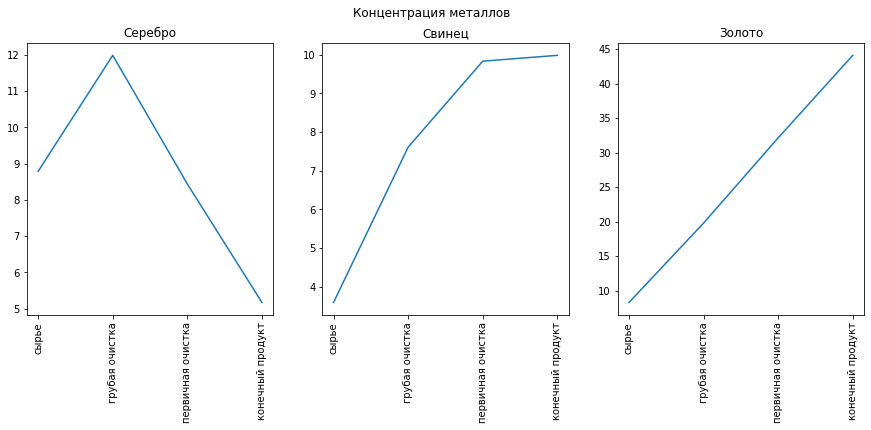

In [289]:
processes = ['сырье', 'грубая очистка', 'первичная очистка', 'конечный продукт']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(processes, concentrate_ag_list)
ax1.set_title('Серебро')
ax1.tick_params(axis='x', labelrotation = 90)

ax2.plot(processes, concentrate_pb_list)
ax2.set_title('Свинец')
ax2.tick_params(axis='x', labelrotation = 90)
                
ax3.plot(processes, concentrate_au_list)
ax3.set_title('Золото')
ax3.tick_params(axis='x', labelrotation = 90)                

fig.suptitle('Концентрация металлов')

Как видно из средних значений концентрация металлов концентрация золота растет по мере выполнения технологического процесса, концентрация свинца незначительно растет от этапа к этапу, концентрация серебра же падает.

Рассмотрим размер гранул перед грубой очисткой (rougher_input_feed_size) и перед первичной очисткой (primary_cleaner_input_feed_size) для обучающей и тестовой выборки.

In [290]:
# Значения по обучающей выборке перед грубой очисткой
gold_recovery_train_filled['rougher_input_feed_size'].describe()

count    14149.000000
mean        59.962270
std         23.163772
min          9.659576
25%         48.917474
50%         55.292117
75%         65.949832
max        484.967466
Name: rougher_input_feed_size, dtype: float64

In [291]:
# Значения по тестовой выборке перед грубой очисткой
gold_recovery_test['rougher_input_feed_size'].describe()

count    5229.000000
mean       55.863978
std        18.914656
min         0.046369
25%        43.911874
50%        50.772729
75%        62.265394
max       392.494040
Name: rougher_input_feed_size, dtype: float64

In [292]:
# Значения по обучающей выборке перед первичной очисткой
gold_recovery_train_filled['primary_cleaner_input_feed_size'].describe()

count    14149.000000
mean         7.322310
std          0.614062
min          1.080000
25%          6.960000
50%          7.290000
75%          7.700000
max         10.470000
Name: primary_cleaner_input_feed_size, dtype: float64

In [293]:
# Значения по тестовой выборке перед первичной очисткой
gold_recovery_test['primary_cleaner_input_feed_size'].describe()

count    5229.000000
mean        7.271546
std         0.605887
min         5.650000
25%         6.900000
50%         7.250000
75%         7.600000
max        15.500000
Name: primary_cleaner_input_feed_size, dtype: float64

Text(0.5, 1.0, 'Размер гранул перед грубой очисткой')

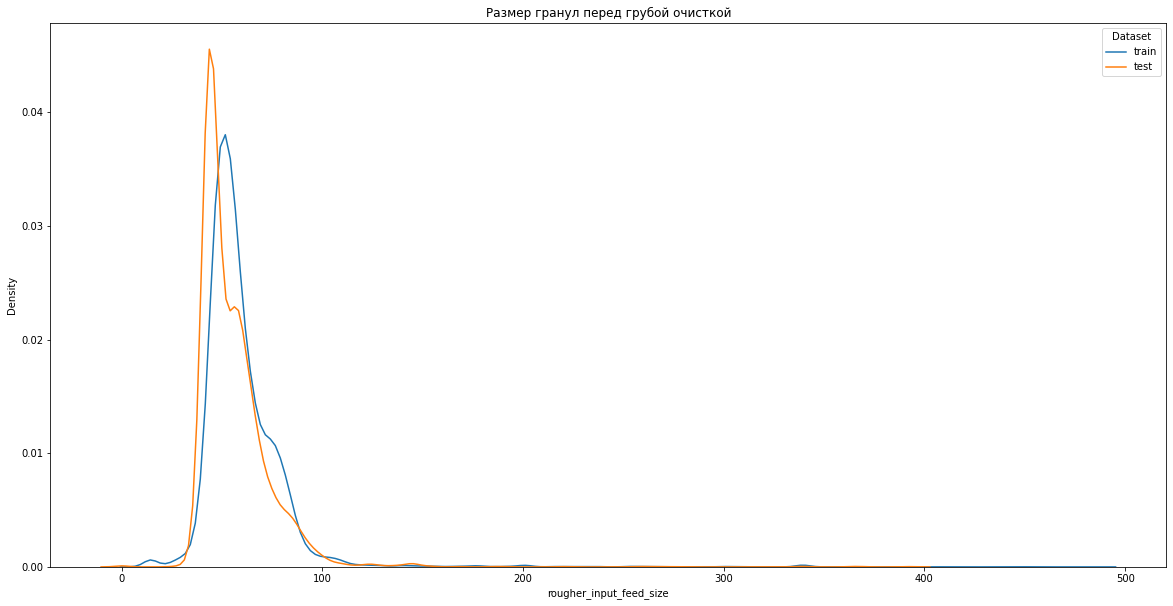

In [294]:
# Построим график для размера гранул перед грубой очисткой
for dataset,name in zip([gold_recovery_train_filled,gold_recovery_test],
                       ['train','test']):
    subset = dataset['rougher_input_feed_size']

    sns.distplot(subset, hist = False, kde = True,
                 label = name)
plt.legend(prop={'size': 10}, title = 'Dataset')
plt.rcParams["figure.figsize"] = (10,6)
plt.title('Размер гранул перед грубой очисткой')

Text(0.5, 1.0, 'Размер гранул перед первичной очисткой')

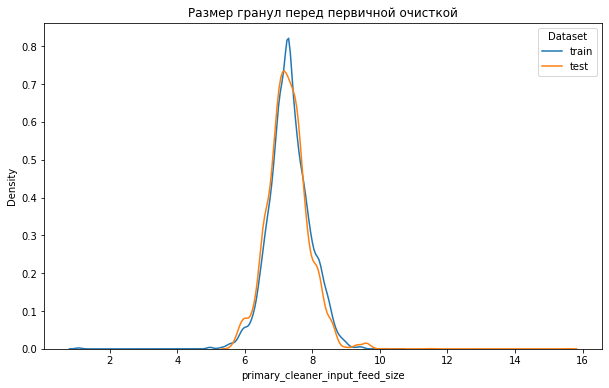

In [295]:
# Построим график для размера гранул перед первичной очисткой
for dataset,name in zip([gold_recovery_train_filled,gold_recovery_test],
                       ['train','test']):
    subset = dataset['primary_cleaner_input_feed_size']

    sns.distplot(subset, hist = False, kde = True,
                 label = name)
plt.legend(prop={'size': 10}, title = 'Dataset')
plt.rcParams["figure.figsize"] = (10,6)
plt.title('Размер гранул перед первичной очисткой')

Распределение размера гранул перед грубой очисткой ненмого отличается для обучающей и тестовой выборки. Размер гранул в обучающей выборке ненмого больше чем в тестовой. Отличаются средние: для обучающей выборки - 59.96, для тестовой выборки - 55.86.

Распределение размера гранул перед первичной очисткой сильно не различаются для обучающей и тестовой выборки. Средние практически равны: для обучающей выборки - 7.32, для тестовой выборки - 7.27.

In [296]:
# Составим таблицу с суммарной концентрацией всех веществ на разных стадиях
elements = ['au', 'ag', 'pb', 'sol']
processes = ['rougher_input_feed_',
             'rougher_output_concentrate_',
             'primary_cleaner_output_concentrate_',
             'final_output_concentrate_'
            ]
data_concentrate = pd.DataFrame(columns=['raw', 'rougher', 'primary_cleaner', 'final'])

for i in range(len(processes)):
    au = gold_recovery_full[processes[i]+'au']
    ag = gold_recovery_full[processes[i]+'ag']
    pb = gold_recovery_full[processes[i]+'pb']
    sol = gold_recovery_full[processes[i]+'sol']
    data_concentrate[data_concentrate.columns[i]] = au + ag + pb + sol

In [297]:
data_concentrate.head(10)

,raw,rougher,primary_cleaner,final
0,51.680034,66.424950,72.640924,63.644396
1,50.659114,67.012710,72.543485,63.957723
2,50.609929,66.103793,72.095042,64.311180
3,51.061546,65.752751,59.957723,63.573449
4,47.859163,65.908382,71.321010,64.004667
5,48.838521,64.955919,70.607932,63.646320
6,49.120760,65.372419,71.165854,63.156407
7,50.790724,65.180132,71.533310,62.908843
8,50.550288,65.625127,72.072013,64.185763
9,51.941235,65.408849,71.887397,64.185200


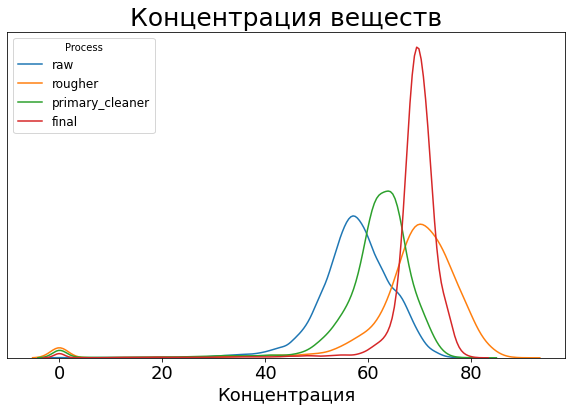

In [298]:
for column in data_concentrate.columns:    
    sns.distplot(data_concentrate[column], hist = False, kde = True,
                 label = column)
    
plt.tick_params(
    axis='y',             
    left=False,      
    labelleft=False)
plt.legend(prop={'size': 12}, title = 'Process')
plt.title('Концентрация веществ', fontsize=25)

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["legend.title_fontsize"] = 'medium'
plt.xlabel('Концентрация', fontsize=18)
plt.ylabel('')
plt.xticks(fontsize=18)
plt.show()

Как видно из графика для данных rougher, primary_cleaner, final среди значений есть выбросы около 0.

In [299]:
# Функция, удаляющая выбросы меньше числа n

def drop_incorrect_values(data, n): 
    indexes = []

    for i in elements:
        for j in processes:
            try:
                index = data[data[j+i] < n].index        
                indexes.append(index)
            except:
                pass

    result_index = pd.Int64Index([])
    for index in indexes:
        result_index = result_index.union(index, sort=False)
    
    data_p = data.drop(index = result_index, axis = 0)
    
    return data_p   

In [300]:
gold_recovery_full_p = drop_incorrect_values(gold_recovery_full, 2)
gold_recovery_train_p = drop_incorrect_values(gold_recovery_train_filled, 2)

Проверим графики еще раз, чтобы убедиться что все выбросы были удалены из датасета.

In [301]:
data_concentrate_p = pd.DataFrame(columns=['raw', 'rougher', 'primary_cleaner', 'final'])

for i in range(len(processes)):
    au = gold_recovery_full_p[processes[i]+'au']
    ag = gold_recovery_full_p[processes[i]+'ag']
    pb = gold_recovery_full_p[processes[i]+'pb']
    sol = gold_recovery_full_p[processes[i]+'sol']
    data_concentrate_p[data_concentrate.columns[i]] = au + ag + pb + sol

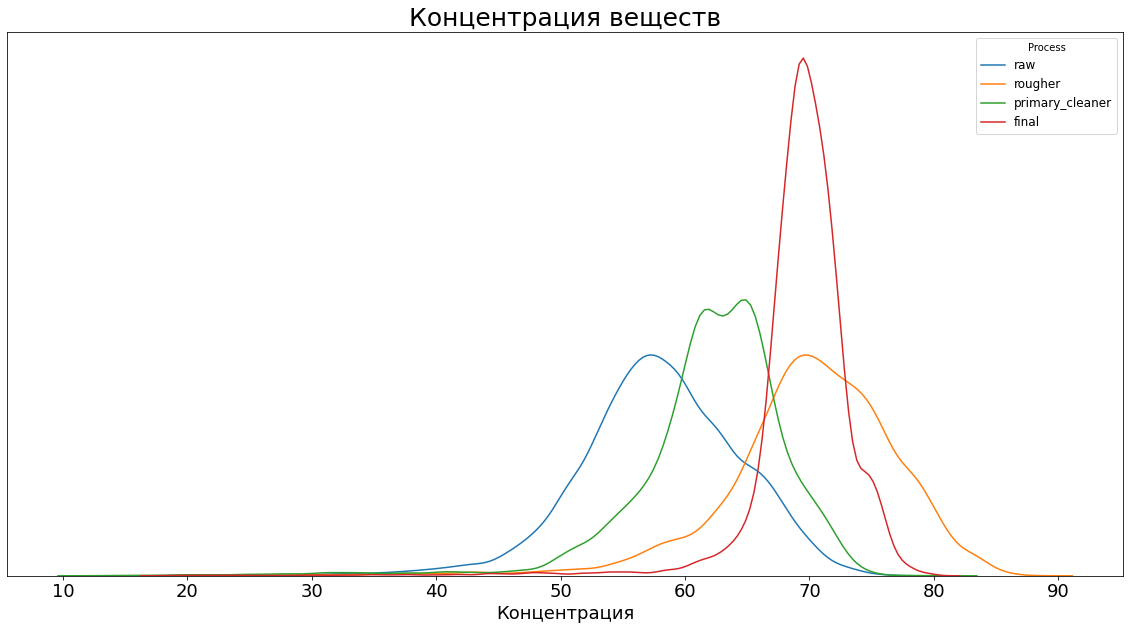

In [302]:
for column in data_concentrate_p.columns:    
    sns.distplot(data_concentrate_p[column], hist = False, kde = True,
                 label = column)
    
plt.tick_params(
    axis='y',             
    left=False,      
    labelleft=False)
plt.legend(prop={'size': 12}, title = 'Process')
plt.title('Концентрация веществ', fontsize=25)

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["legend.title_fontsize"] = 'medium'
plt.xlabel('Концентрация', fontsize=18)
plt.ylabel('')
plt.xticks(fontsize=18)
plt.show()

**Вывод: Из произведенного анализа средних значений концентраций металлов, концентрация золота растет по мере выполнения технологического процесса, концентрация свинца незначительно растет от этапа к этапу, концентрация серебра же падает. Распределение размера гранул перед грубой очисткой немного отличается для обучающей и тестовой выборки. Перед первичной очисткой распределение размера гранул не сильно различаются для обучающей и тестовой выборки. При анализе суммарной концентрации всех веществ на разных стадиях из датасета были удалены выбросные значения.**

## Модель

Напишем функцию для вычисление метрики sMAPE для поставленной нам задачи.

In [303]:
def sMAPE(target, pred):
    return np.mean(abs(target - pred) / ((abs(target) + abs(pred)) / 2) * 100)

In [304]:
sMAPE_scorer = make_scorer(sMAPE)

In [305]:
def sMAPE_final(sMAPE_rougher, sMAPE_final):    
    return 0.25 * sMAPE_rougher + 0.75 * sMAPE_final

In [306]:
# Создадим датасет с признакими, исключив из исходного датасета целевые признаки и дату
drop_list = missing_in_test
drop_list.append('date')
features = gold_recovery_train_p.drop(drop_list, axis=1)
# Создадим датасет с целевым признаком
target_rougher = gold_recovery_train_p['rougher_output_recovery']
target_final = gold_recovery_train_p['final_output_recovery']

In [307]:
features.head(5)

,primary_cleaner_input_sulfate,primary_cleaner_input_depressant,primary_cleaner_input_feed_size,primary_cleaner_input_xanthate,primary_cleaner_state_floatbank8_a_air,primary_cleaner_state_floatbank8_a_level,primary_cleaner_state_floatbank8_b_air,primary_cleaner_state_floatbank8_b_level,primary_cleaner_state_floatbank8_c_air,primary_cleaner_state_floatbank8_c_level,...,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
6,117.322323,12.469088,7.25,0.895207,1597.532455,-500.985364,1602.816321,-500.696736,1603.572091,-500.256955,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470


In [308]:
target_rougher.head(5)

0    87.107763
1    86.843261
2    86.842308
3    87.226430
6    88.168065
Name: rougher_output_recovery, dtype: float64

In [309]:
target_final.head(5)

0    70.541216
1    69.266198
2    68.116445
3    68.347543
6    69.300835
Name: final_output_recovery, dtype: float64

In [310]:
gold_recovery_test_with_target = gold_recovery_test.merge(gold_recovery_full_p, how='inner')

In [311]:
features_test = gold_recovery_test_with_target.drop(drop_list, axis=1)
target_rougher_test = gold_recovery_test_with_target['rougher_output_recovery']
target_final_test = gold_recovery_test_with_target['final_output_recovery']

In [312]:
features_test.head(5)

,primary_cleaner_input_sulfate,primary_cleaner_input_depressant,primary_cleaner_input_feed_size,primary_cleaner_input_xanthate,primary_cleaner_state_floatbank8_a_air,primary_cleaner_state_floatbank8_a_level,primary_cleaner_state_floatbank8_b_air,primary_cleaner_state_floatbank8_b_level,primary_cleaner_state_floatbank8_c_air,primary_cleaner_state_floatbank8_c_level,...,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [313]:
target_rougher_test.head(5)

0    89.993421
1    88.089657
2    88.412756
3    87.360133
4    83.236367
Name: rougher_output_recovery, dtype: float64

In [314]:
target_final_test.head(5)

0    70.273583
1    68.910432
2    68.143213
3    67.776393
4    61.467078
Name: final_output_recovery, dtype: float64

Так в датасете присутствуют количественные признаки с разными разбросами значений, отмасштабируем признаки. Это потребуется для корректной работы модели линейной регрессии.

In [315]:
scaler = StandardScaler()
scaler.fit(features)
features_scaled = scaler.transform(features)
features_scaled = pd.DataFrame(features_scaled, columns = features.columns)

In [316]:
features_scaled.head(5)

,primary_cleaner_input_sulfate,primary_cleaner_input_depressant,primary_cleaner_input_feed_size,primary_cleaner_input_xanthate,primary_cleaner_state_floatbank8_a_air,primary_cleaner_state_floatbank8_a_level,primary_cleaner_state_floatbank8_b_air,primary_cleaner_state_floatbank8_b_level,primary_cleaner_state_floatbank8_c_air,primary_cleaner_state_floatbank8_c_level,...,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
0,-0.290461,0.335122,-0.137583,0.282837,-0.438446,-0.280548,-0.422458,-0.815826,-0.435706,-0.256712,...,-1.083149,-0.479249,-0.653302,-0.766344,-1.170724,-0.389530,-0.862082,-0.433548,-0.929879,-2.696028
1,-0.329944,0.385405,-0.137583,0.319914,-0.232360,-0.339726,-0.235203,-0.302891,-0.239546,-0.276345,...,-1.087565,-0.537620,-0.681585,-0.708984,-1.151276,-0.437761,-0.878623,-0.436399,-0.956301,-2.530453
2,-0.378785,0.690784,-0.137583,0.289520,-0.034094,-0.312787,-0.048561,-0.325901,-0.044220,-0.323420,...,-1.083476,-0.479886,-0.688732,-0.705626,-1.145855,-0.436701,-0.873548,-0.434743,-0.951066,-2.575306
3,-0.420612,0.692538,-0.137583,0.304116,-0.046490,-0.341116,-0.046479,-0.297035,-0.056982,-0.319119,...,-1.079610,-0.447681,-0.672305,-0.706648,-1.163067,-0.412648,-0.879919,-0.428034,-0.955058,-2.536167
4,-0.554166,1.035914,-0.137583,0.033365,-0.065515,-0.342113,-0.030003,-0.328661,-0.032440,-0.304859,...,-1.077756,-0.449885,-0.654890,-0.694915,-1.157438,-0.357708,-0.874069,-0.421536,-0.950896,-2.561034


In [317]:
features_test_scaled = scaler.transform(features_test)
features_test_scaled = pd.DataFrame(features_test_scaled, columns = features.columns)

In [318]:
features_test_scaled.head(5)

,primary_cleaner_input_sulfate,primary_cleaner_input_depressant,primary_cleaner_input_feed_size,primary_cleaner_input_xanthate,primary_cleaner_state_floatbank8_a_air,primary_cleaner_state_floatbank8_a_level,primary_cleaner_state_floatbank8_b_air,primary_cleaner_state_floatbank8_b_level,primary_cleaner_state_floatbank8_c_air,primary_cleaner_state_floatbank8_c_level,...,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
0,1.969027,1.791562,1.232104,0.326203,-1.615998,-0.319551,-1.585640,-0.304561,-1.560466,-0.318404,...,-1.441667,-0.388415,-1.426329,-0.708265,-1.509494,1.321914,-1.421043,-0.422433,1.238390,0.206286
1,2.092963,1.789872,1.232104,0.287397,-1.617586,-0.314558,-1.593962,-0.300170,-1.590145,-0.274076,...,-1.435447,-0.405837,-1.404686,-0.680217,-1.507490,-1.103477,-1.419938,-0.425636,0.947214,0.203277
2,2.089387,1.160410,0.748038,0.302261,-1.619805,-0.338639,-1.587813,-0.299747,-1.575691,-0.362215,...,-1.452673,-0.407225,-1.411139,-0.700440,-1.488184,-0.454143,-1.415359,-0.417077,0.942882,0.181315
3,2.091446,0.897514,0.506005,-0.051149,-1.611025,-0.279106,-1.598661,-0.282579,-1.560268,-0.247305,...,-1.439952,-0.399161,-1.415294,-0.677509,-1.517963,-0.455876,-1.410780,-0.420541,0.934948,0.233617
4,1.653176,0.501050,0.324480,-0.205654,-1.598140,-0.336855,-1.593401,-0.291683,-1.544926,-0.321620,...,-1.441341,-0.446310,-1.419131,-0.693154,-1.481878,-0.680418,-1.406200,-0.430704,0.944345,0.174922


In [319]:
model = RandomForestRegressor(random_state=RANDOM_STATE)

scores = cross_val_score(model, features_scaled, target_rougher, cv=5, scoring=sMAPE_scorer) 
final_score_rougher = sum(scores)/len(scores)
print('Средняя оценка качества модели:', final_score_rougher)

Средняя оценка качества модели: 8.433150252780056


In [320]:
model = RandomForestRegressor(random_state=RANDOM_STATE)

scores = cross_val_score(model, features_scaled, target_final, cv=5, scoring=sMAPE_scorer) 
final_score_final = sum(scores)/len(scores)
print('Средняя оценка качества модели:', final_score_final)

Средняя оценка качества модели: 9.147314229140779


In [321]:
forest_score = sMAPE_final(final_score_rougher, final_score_final)

In [322]:
forest_score

8.968773235050598

In [323]:
model = LinearRegression()

scores = cross_val_score(model, features_scaled, target_rougher, cv=5, scoring=sMAPE_scorer)
final_score_rougher = sum(scores)/len(scores)
print('Средняя оценка качества модели:', final_score_rougher)

Средняя оценка качества модели: 7.176634855531629


In [324]:
model = LinearRegression()

scores = cross_val_score(model, features_scaled, target_final, cv=5, scoring=sMAPE_scorer) 
final_score_final = sum(scores)/len(scores)
print('Средняя оценка качества модели:', final_score_final)

Средняя оценка качества модели: 9.787968821462432


In [325]:
linear_score = sMAPE_final(final_score_rougher, final_score_final)

In [326]:
linear_score

9.13513532997973

In [327]:
model = DecisionTreeRegressor(random_state=RANDOM_STATE)

scores = cross_val_score(model, features_scaled, target_rougher, cv=5, scoring=sMAPE_scorer) 
final_score_rougher = sum(scores)/len(scores)
print('Средняя оценка качества модели:', final_score_rougher)

Средняя оценка качества модели: 12.932946063653139


In [328]:
model = DecisionTreeRegressor(random_state=RANDOM_STATE)

scores = cross_val_score(model, features_scaled, target_final, cv=5, scoring=sMAPE_scorer) 
final_score_final = sum(scores)/len(scores)
print('Средняя оценка качества модели:', final_score_final)

Средняя оценка качества модели: 17.23673969892669


In [329]:
tree_score = sMAPE_final(final_score_rougher, final_score_final)

In [330]:
tree_score

16.160791290108303

Среди трех выбранных моделей, самое низкое значение метрики итоговое sMAPE показала модель случайного леса (8.97). Проверим выбранную модель на тестовой выборке.

In [331]:
def rfr_objective(trial):
    
    param = {
    'max_depth': trial.suggest_int('max_depth', 2, 30),
    'n_estimators': trial.suggest_int('n_estimators', 10,30),
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10), 
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 8),         
    }
    
    rfr = RandomForestRegressor(**param, random_state = RANDOM_STATE)
    scores = cross_val_score(rfr, features_scaled, target_final, 
                             cv = KFold(n_splits = 5, shuffle = True, random_state = RANDOM_STATE),
                             scoring=sMAPE_scorer
                            )
    return scores.mean()

In [332]:
study = optuna.create_study()
study.optimize(rfr_objective, n_trials=10, timeout=600)
rfr_params = study.best_params
rfr_score = study.best_value*-1

print(f'Лучший результат: {rfr_score}\n')
print(f'Оптимизированные параметры: {rfr_params}\n')

[I 2023-04-21 12:17:31,381] A new study created in memory with name: no-name-b36a5a9e-dc24-4cfc-9703-0e015949c7b0
[I 2023-04-21 12:18:03,926] Trial 0 finished with value: 5.934491702955741 and parameters: {'max_depth': 9, 'n_estimators': 24, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 5.934491702955741.
[I 2023-04-21 12:18:41,738] Trial 1 finished with value: 5.768114325718765 and parameters: {'max_depth': 10, 'n_estimators': 26, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 1 with value: 5.768114325718765.
[I 2023-04-21 12:19:07,508] Trial 2 finished with value: 5.528993972407086 and parameters: {'max_depth': 14, 'n_estimators': 15, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 2 with value: 5.528993972407086.
[I 2023-04-21 12:19:59,701] Trial 3 finished with value: 5.332924682172267 and parameters: {'max_depth': 20, 'n_estimators': 25, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 3 with value: 5.33292468

Лучший результат: -5.319586734921309

Оптимизированные параметры: {'max_depth': 27, 'n_estimators': 25, 'min_samples_split': 8, 'min_samples_leaf': 3}



Лучший результат: -5.32569517526634

Оптимизированные параметры: {'max_depth': 18, 'n_estimators': 30, 'min_samples_split': 9, 'min_samples_leaf': 4}

In [333]:
model_rougher = RandomForestRegressor(random_state=RANDOM_STATE,
                                      max_depth=18,
                                      n_estimators=30,
                                      min_samples_split=9,
                                      min_samples_leaf=4)
model_rougher.fit(features_scaled, target_rougher)

model_final = RandomForestRegressor(random_state=RANDOM_STATE,
                                      max_depth=18,
                                      n_estimators=30,
                                      min_samples_split=9,
                                      min_samples_leaf=4)
model_final.fit(features_scaled, target_final)

RandomForestRegressor(max_depth=18, min_samples_leaf=4, min_samples_split=9,
                      n_estimators=30, random_state=12345)

In [334]:
predicted_rougher = model_rougher.predict(features_test)
predicted_final = model_final.predict(features_test)

In [335]:
test_score_rougher = sMAPE(target_rougher_test, predicted_rougher)
print('Оценка качества модели (rougher):', test_score_rougher)
test_score_final = sMAPE(target_final_test, predicted_final)
print('Оценка качества модели (final):', test_score_final)

Оценка качества модели (rougher): 4.521018552164001
Оценка качества модели (final): 7.235768665786031


In [336]:
test_score = sMAPE_final(test_score_rougher, test_score_final)

In [337]:
test_score

6.557081137380523

Для оценки модели на адекватность, модель должна быть умнее тривиальной модели. В нашем исследовании в качестве тривиальной модели будем использовать модель DummyRegressor со статегией mean, которая возвращает среднее значение целевого параметра.

In [338]:
dummy_regr_rougher = DummyRegressor(strategy="mean")
dummy_regr_rougher.fit(features_scaled, target_rougher)

dummy_regr_final = DummyRegressor(strategy="mean")
dummy_regr_final.fit(features_scaled, target_final)

DummyRegressor()

In [339]:
dummy_regr_rougher_pred = dummy_regr_rougher.predict(features_test)
dummy_regr_final_pred = dummy_regr_final.predict(features_test)

In [340]:
dummy_score_rougher = sMAPE(target_rougher_test, dummy_regr_rougher_pred)
dummy_score_final = sMAPE(target_final_test, dummy_regr_final_pred)

In [341]:
dummy_score = sMAPE_final(dummy_score_rougher, dummy_score_final)

In [342]:
dummy_score

7.146437574263466

Наша модель прошла оценку на адекватность, занчение целевой метрики итоговое sMAPE меньше чем у тривиальной модели.

**Вывод: Для данной задачи были обучены три модели: модель случайного леса, модель линейной регрессии, модель решающего дерева. Качество моделей было оценено кросс-валидацией. Наилучшие значние метрики sMAPE показала модель случайного леса. Для проверки адекватности модели, модель сравнивалась с моделью DummyRegressor со статегией mean, возвращающей среднее значение целевого параметра. Выбранная модель показала лучшие значение целевой метрики чем тривиальная модель.**

## Общий вывод

В рамках данного исследования были загружены и изучены производственные данные восстановления золота из золотосодержащей руды. Данные были проверены на корректность, обработаны пропущенные значения.  

Анализ данных показал, что концентрация золота растет по мере выполнения технологического процесса, концентрация свинца незначительно растет от этапа к этапу, концентрация серебра же падает. Распределение размера гранул перед грубой очисткой немного отличается для обучающей и тестовой выборки. Перед первичной очисткой распределение размера гранул не сильно различаются для обучающей и тестовой выборки. При анализе суммарной концентрации всех веществ на разных стадиях из датасета были удалены выбросные значения.  

Были обучены три типо моделей: модель решающего дерева, модель случайного леса и модель линейной регресии. По условию задачи для исследования использовалась модель случайного леса. Модели были обучены на тренировочной выборке и оценены кросс-валидацией. Наилучшие значние метрики sMAPE показала модель линейной регресии. Значение итогового sMAPE на тестовой выборке составило 6.56. Для проверки адекватности модели, модель сравнивалась с моделью DummyRegressor со статегией mean, возвращающей среднее значение целевого параметра. Выбранная модель показала лучшие значение целевой метрики чем тривиальная модель, применение данной модели в бизнесе оправдано. В дальнейшем можно приступить к расчету экономического эффекта от внедрения модели.